# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [0]:
!kill -9 -1

In [4]:
import gc
import copy
import json
import csv
import urllib
import os
from google.colab import files
!pip3 install -q torch torchvision
!pip3 install -q Pillow==4.0.0

    100% |████████████████████████████████| 2.0MB 13.3MB/s 
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
torchvision 0.2.2.post3 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
scikit-image 0.14.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [0]:
train_folder = "train_kaggle/"
test_folder = "test_kaggle/"

In [0]:
!wget "https://www.dropbox.com/s/cupinvuotopehty/train.zip?dl=0"
!unzip -q "train.zip?dl=0"

train_folder = "train_kaggle/"
print('Number of files in the train folder', len(os.listdir(train_folder)))

!wget "https://www.dropbox.com/s/7xakfl2r9gn5p1j/test.zip?dl=0"
!unzip -q "test.zip?dl=0"

test_folder = "test_kaggle/"
print('Number of files in the test folder', len(os.listdir(test_folder)))

In [0]:
import torch
from torchvision import models
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from train import train_model
from visualize import *
from dataset import *

device = torch.device("cuda:0")

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

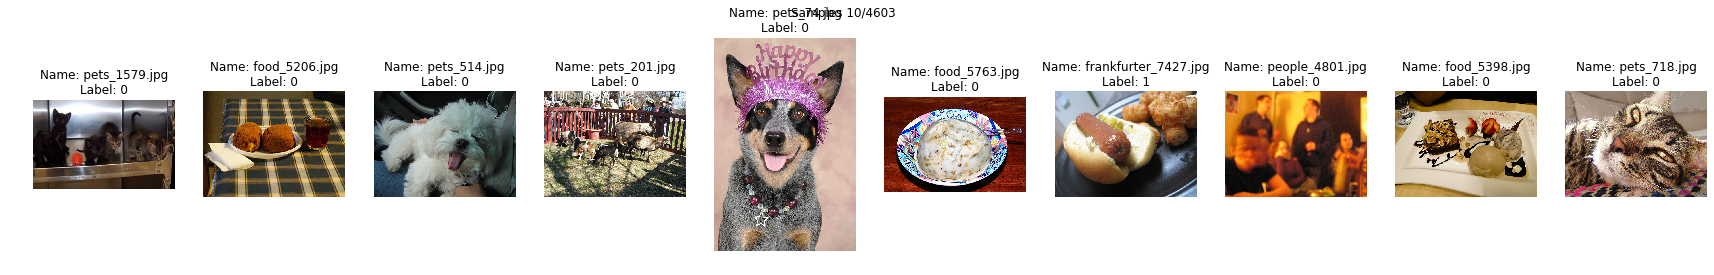

In [7]:
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), len(orig_dataset), replace=False)

visualize_samples(orig_dataset, indices, plt, "Samples")

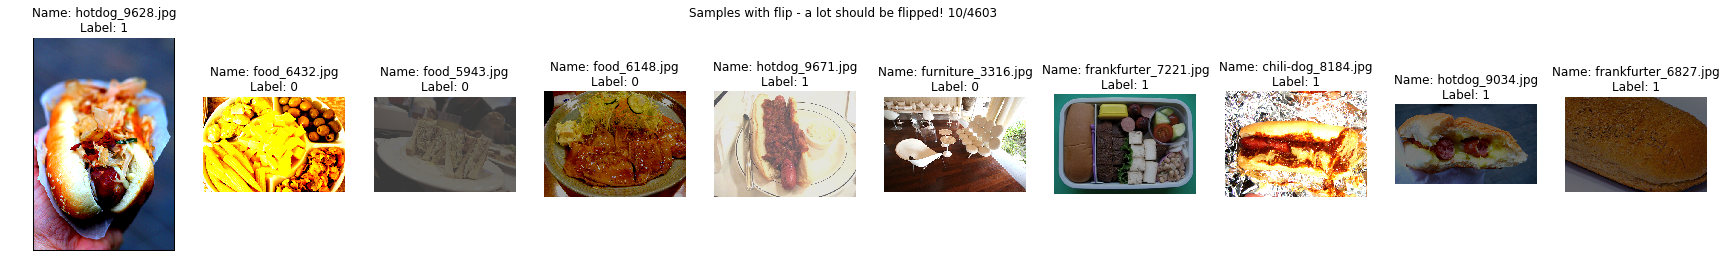

In [15]:
tfs = transforms.Compose([
                           #transforms.Resize((224, 224)),
                           #transforms.RandomRotation(15),
                           #transforms.RandomRotation(45),
                           transforms.ColorJitter(.75, .75, .75, 0),                       
                       ])
dataset = HotdogOrNotDataset(train_folder, transform=tfs)

visualize_samples(dataset, indices, plt, "Samples with flip - a lot should be flipped!")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [0]:
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           #Don't change it!
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
train_aug_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.RandomHorizontalFlip(.5),
                           #transforms.RandomRotation(45),
                           #transforms.ColorJitter(.2, .5, .5, 0), не работает!
                           transforms.ColorJitter(.75, .75, .75, 0),
                           transforms.RandomResizedCrop(224, scale=(.5, 1.)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           #Don't change it!
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           #Don't change it!
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [0]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_aug_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировки

# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 53382923.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


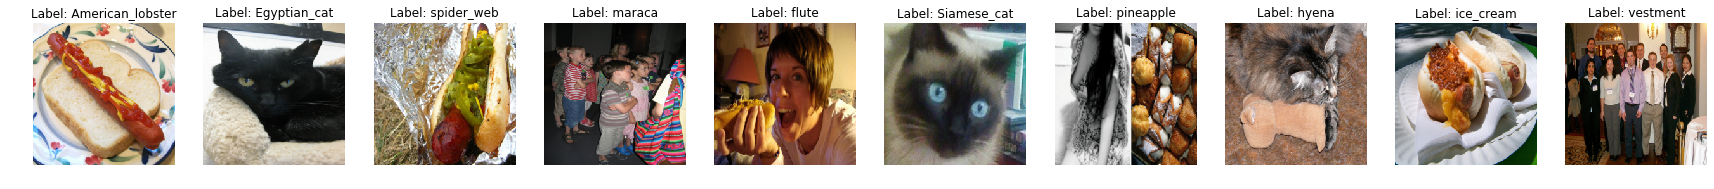

In [20]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}
imagenet_classes = load_imagenet_classes()
    
model = models.resnet18(pretrained=True)
model = model.to(device)

# TODO: Run this model on 10 random images of your dataset and visualize what it predicts
loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, sampler=train_sampler)
for x, y, _ in loader:
    plt.figure(figsize=(10*3,4))
    x_gpu = x.to(device)
    y_gpu = y.to(device)        
    prediction = model(x_gpu)  
    _, indices = torch.max(prediction, 1)
    for i in range(10):    
        img = x[i].permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        plt.subplot(1,10,i+1)
        plt.title("Label: %s" % imagenet_classes[int(indices[i])])
        plt.imshow(img)
        plt.grid(False)
        plt.axis('off')   
    
    break

# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - сделать новый последний слой и тренировать только его, заморозив остальные.

In [0]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
train_history, val_history = train_model(model, device, train_loader, val_loader, loss, optimizer, 5)

# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - добавить новый слой и обучать всю модель целиком.

In [0]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_history, val_history = train_model(model, device, train_loader, val_loader, loss, optimizer, 5)

# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [0]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
loss = nn.CrossEntropyLoss()

# Train new layer with learning speed 0.01 and old layers with 0.001
optimizer = optim.SGD([
                {'params': model.conv1.parameters()},
                {'params': model.bn1.parameters()},
                {'params': model.relu.parameters()},
                {'params': model.maxpool.parameters()},
                {'params': model.layer1.parameters()},
                {'params': model.layer2.parameters()},
                {'params': model.layer3.parameters()},
                {'params': model.layer4.parameters()},
                {'params': model.avgpool.parameters()},
                {'params': model.fc.parameters(), 'lr': 1e-2}
            ], lr=1e-3, momentum=0.9)
train_history, val_history = train_model(model, device, train_loader, val_loader, loss, optimizer, 5)

# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

И теперь можно визуализировать false positives и false negatives.

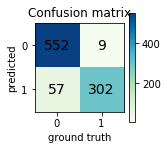

In [24]:
predictions, gt = evaluate_model(model, device, 64, train_dataset, val_indices)
visualize_confusion_matrix(predictions, gt, plt)

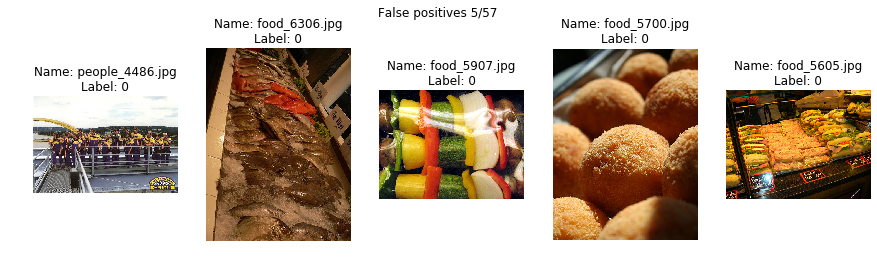

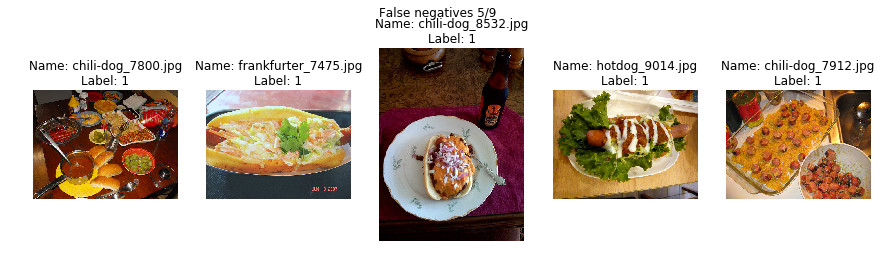

In [26]:
data = np.vstack((predictions, gt, val_indices)).T

# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive_indices = data[(data[:, 0] == 1) & (data[:, 1] == 0)][:, 2]
visualize_samples(orig_dataset, false_positive_indices, plt, "False positives", count=5)

# TODO: Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
false_negatives_indices = data[(data[:, 0] == 0) & (data[:, 1] == 1)][:, 2]
visualize_samples(orig_dataset, false_negatives_indices, plt, "False negatives", count=5)

# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.9**.

## ResNet50

In [0]:
def scheduler(optimizer, max_epoch, len_epoch):
    func = lambda epoch: (epoch+1) / max_epoch if epoch < max_epoch else (len_epoch-epoch) / (len_epoch-max_epoch+1)
    return optim.lr_scheduler.LambdaLR(optimizer, func)

In [0]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
for name, child in model.named_children():
    if name in ['layer3', 'layer4']:
        print(name + ' is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name + ' is frozen')
        for param in child.parameters():
            param.requires_grad = False
model.fc = nn.Sequential(
           #nn.Linear(num_ftrs, 1024),
           #nn.ReLU(inplace=True),
           #nn.BatchNorm1d(1024),
           #nn.Dropout(.2),
           
           #nn.Linear(1024, 1024),
           #nn.ReLU(inplace=True),
           ##nn.BatchNorm1d(1024),
           #nn.Dropout(.2),
    
           nn.Linear(num_ftrs, 2)
)
model = model.to(device)
loss = nn.CrossEntropyLoss()

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is frozen


In [0]:
gc.collect()
lr = 1e-3 * 16
_ro = .625
alpha = 1e-2
optimizer = optim.SGD([
                #{'params': model.conv1.parameters()},
                #{'params': model.bn1.parameters()},
                #{'params': model.layer1.parameters()},
                #{'params': model.layer2.parameters()},
                {'params': model.layer3.parameters()},
                {'params': model.layer4.parameters()},
                {'params': model.fc.parameters(), 'lr': lr}
            ], lr=1e-3 * 2 * 2, nesterov=True, momentum=1-_ro, weight_decay=alpha)
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: (.1**(1/3))**(epoch // 2))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1**(1/3), patience=1, verbose=True)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 100, scheduler)

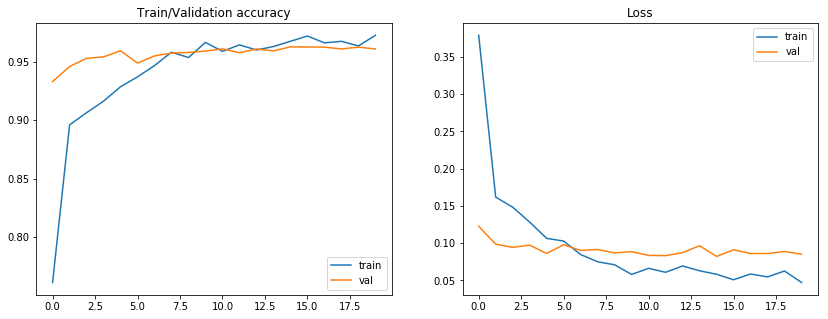

In [0]:
display_history(train_loss_history, val_loss_history, train_score_history, val_score_history, plt)

## VGG11_BN

In [0]:
model = models.vgg11_bn(pretrained=True)
classifier = model.classifier
model.classifier = nn.Sequential(
            classifier[0],
            classifier[1],
            classifier[2],
            classifier[3],
            classifier[4],
            classifier[5],
            nn.Linear(4096, 2),
        )
model = model.to(device)
loss = nn.CrossEntropyLoss()

In [0]:
gc.collect()
optimizer = optim.SGD([
                {'params': model.features.parameters()},
                {'params': model.classifier[0].parameters()},
                {'params': model.classifier[3].parameters()},
                {'params': model.classifier[6].parameters(), 'lr': lr}
            ], lr=1e-3 * 2 * 2, nesterov=True, momentum=1-_ro, weight_decay=alpha)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: .5**epoch)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1**(1/3), patience=2, verbose=True)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 100, scheduler)

## Визуализируйте ошибки лучшей модели

In [0]:
# TODO Visualize false positives and false negatives of the best model on the validation set

# Необязательное задание с большой звездочкой

Поучавствуйте в Kaggle In-Class Hot Dog Recognition Challenge!  
Это соревнование сделано специально для курса и в нем учавствуют только те, кто проходит курс.

В нем участники соревнуются в качестве натренированных моделей, загружая на сайт предсказания своих моделей на тестовой выборке. Разметка тестовой выборке участникам недоступна.
Более подробно о правилах соревнования ниже.

Те, кто проходят курс лично, за высокое место в соревновании получат дополнительные баллы.

Вот ссылка на соревнование:
https://www.kaggle.com/c/hotdogornot

In [0]:
image_id = []
predictions = []
model.eval()
for x,_,id_img in test_loader:
    x_gpu = x.to(device)    
    prediction = model(x_gpu)    
    _, indices = torch.max(prediction, 1)
    image_id += list(id_img)
    predictions += [int(index) for index in indices]
    
with open('subm.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(image_id,predictions))

In [0]:
files.download('subm.csv') 

### Небольшое введение в Kaggle для тех, кто не слышал об этой платформе раньше

В основе своей Kaggle - это платформа для проведения соревнований по машинному обучению. Появилась она в 2010 и, пожалуй, стала самой популярной и известной из всех существующих площадок по машинному обучению. Надо сказать, что Kaggle - это не только соревнования, но и сообщество людей, увлеченных машинным обучением. А судя по Википедии, в 2017 году отметка зарегистрированных пользователей перевалила за миллион. Есть там и обучающие материалы, возможность задавать вопросы, делиться кодом и идеями - просто мечта. 

### Как проходят соревнования? 
Обычно участники скачивают данные для обучения моделей (train data), чтобы затем делать предсказания на тестовых данных (test data). Обучающая выборка содержит как сами данные, так и правильные метки (значения зависимой переменной), чтобы можно было обучить модель. Но тестовые данные ответа не содержат - и нашей целью является предсказание меток по имеющимся данным. Файл с ответами для каждого наблюдения из тестовой выборки загружается на Kaggle и оценивается в соответствии с выбранной метрикой соревнования, а результат является публичным и показывается в общей таблице (ее называют еще лидербордом - leaderboard) - чтобы появилось желание посоревноваться и создать еще более сильную модель. В "настоящих" соревнованиях, которые проходят на Kaggle, есть и денежное вознаграждение для тех участников, кто занимает первые места на лидерборде. Например, в [этом](https://www.kaggle.com/c/zillow-prize-1#description) соревновании, человек, занявший первое место, получил около 1 000 000 долларов. 

Тестовые данные делятся случайным образом в некоторой пропорции. И пока соревнование идет, на лидерборде показываются очки и рейтинг участников только по одной части (Public Leaderboard). А вот когда соревнование заканчивается, то рейтинг участников составляется по второй части тестовых данных (Private Leaderboard). И часто можно видеть, как люди занимавшие первые места на публичной части тестовых данных, оказываются далеко не первыми на закрытой части тестовых данных. Зачем это сделано? Есть несколько причин, но, пожалуй, самой фундаментальной является идея недообучения-переобучения. Всегда возможно, что наша модель настроилась на конкретную выборку, но как она поведет себя на тех данных, которые еще не видела? Разбиение тестовых данных на публичную и скрытую части сделано для того, чтобы отобрать модели, которые имеют большую обобщающую способность. Одним из лозунгов участников соревнований стал "Доверяйте своей локальной кросс-валидации" (Trust your CV!). Есть очень большой соблазн оценивать свою модель по публичной части лидерборда, но лучшей стратегией будет выбирать ту модель, которая дает лучшую метрику на кросс-валидации на обучающей выборке. 

В нашем соревновании публичная часть лидерборда составляет 30%, а скрытая 70%. Вы можете делать до двух попыток в день, а оцениваться попытки будут по F1-мере. Удачи и доверяйте своей локальной валидации! В конце соревнования у вас будет возможность выбрать 2 из всех совершенных попыток - лучшая из этих двух и будет засчитана вам на скрытой части тестовых данных.